In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn as sns

In [ ]:
prices = pd.read_csv("indices.csv")
prices=prices.iloc[:,:13]
prices=prices.dropna()
prices.head()

,Date,S5TELS,S5CONDS,S5CONS,S5ENRS,S5FINL,S5HLTH,S5INDU,S5MATR,S5RLST,S5INFT,S5UTIL,SPX
0,2006-01-04,119.03,260.97,242.36,390.84,432.63,375.34,293.42,191.93,134.22,341.26,162.91,1273.46
1,2006-01-05,119.49,261.37,241.27,386.76,434.19,374.77,292.53,191.74,135.40,343.95,161.86,1273.48
2,2006-01-06,119.63,263.73,242.35,395.48,436.43,377.49,294.18,194.10,137.16,349.49,163.33,1285.45
3,2006-01-09,119.79,265.94,243.22,395.46,438.29,379.38,295.70,193.82,138.14,350.49,162.60,1290.15
4,2006-01-10,119.28,266.40,242.49,398.94,438.27,377.64,294.98,192.71,139.40,350.65,162.67,1289.69


In [3]:
prices["Date"]=pd.to_datetime(prices["Date"])
prices=prices[prices['Date'] <= '2024-12-31']

In [4]:
prices.set_index("Date",inplace=True)

In [ ]:
def calculate_returns(prices):
    # Using log returns for internal calculations; later converted to simple returns for backtesting
    return np.log(prices / prices.shift(1)).dropna()

def compute_annual_return(equity_curve):
    """
    Computes the annualized return based on the equity curve.
    :param equity_curve: pd.Series where the index is dates and values are portfolio values.
    """
    initial_value = equity_curve.iloc[0]
    total_value = equity_curve.iloc[-1]
    n_days = len(equity_curve)
    return (total_value / initial_value) ** (252 / n_days) - 1

def compute_annual_sharpe(equity_curve, rf=0):
    """
    Computes the annualized Sharpe ratio based on daily portfolio returns.
    :param equity_curve: pd.Series of portfolio values.
    :param rf: risk-free rate (default = 0)
    """
    daily_returns = equity_curve.pct_change().dropna()
    if daily_returns.std() == 0:
        return 0.0
    return (daily_returns.mean() - rf) / daily_returns.std() * np.sqrt(252)

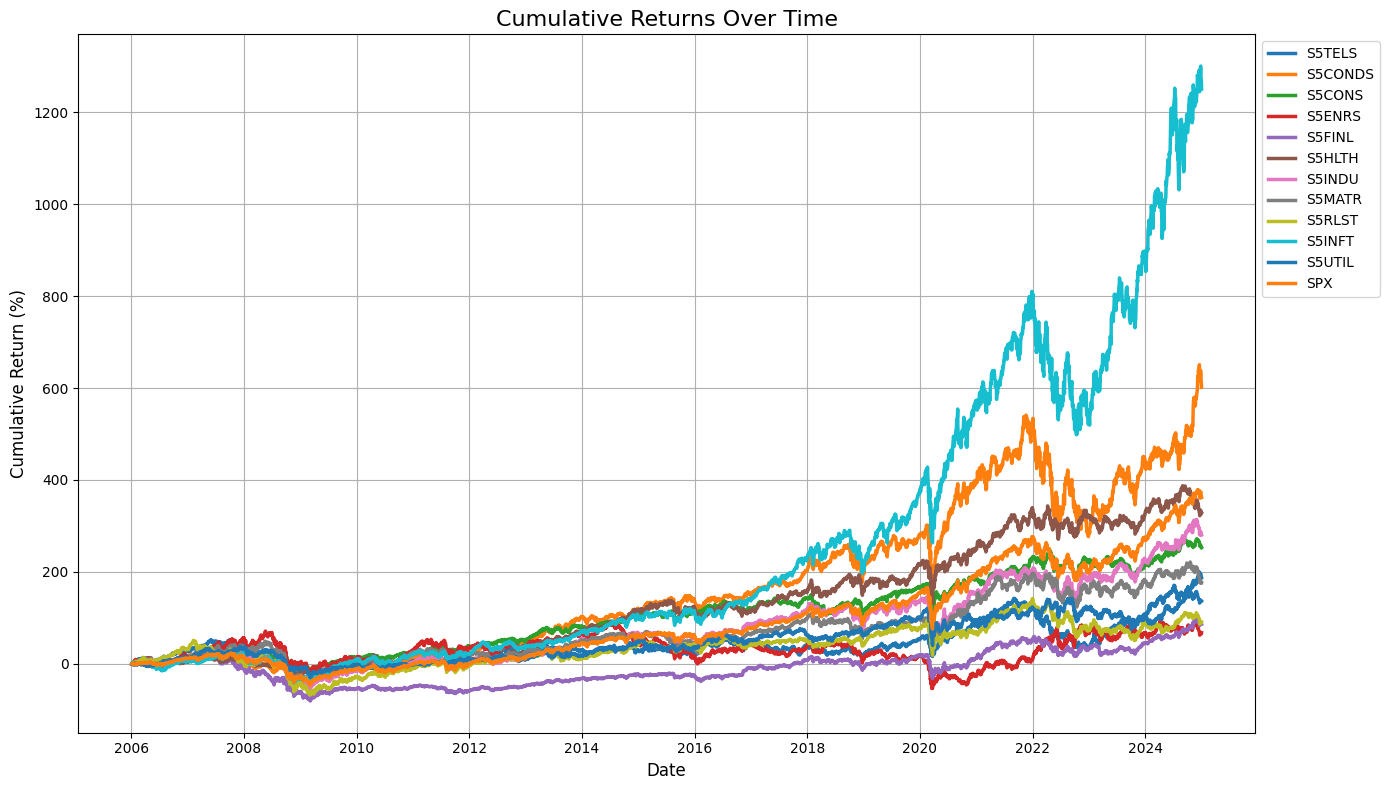

In [ ]:
returnsdf = calculate_returns(prices)

# Compute cumulative returns from log returns.
# For log returns, the cumulative return is: exp(sum(log_return))
cumulative_returns = np.exp(returnsdf.cumsum())

# Assuming cumulative_returns is already defined
plt.figure(figsize=(14, 8))

# Plot each line with increased linewidth
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, (cumulative_returns[column] - 1.0) * 100, label=column, linewidth=2.5)


plt.title('Cumulative Returns Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (%)', fontsize=12)
plt.grid(True)  # Add grid
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.covariance import LedoitWolf

def compute_mvo_weights(window, w_prev, trading_cost, Rf=0.01):
    """
    Compute mean–variance optimal weights with a turnover penalty.

    Parameters
    ----------
    window : pandas.DataFrame
        Log returns for the lookback window.
    w_prev : array-like
        Previous-period portfolio weights (length n).
    trading_cost : float
        Cost per unit of turnover.
    Rf : float, default 0.01
        Risk-free rate (in simple-return terms).

    Returns
    -------
    w : ndarray
        New portfolio weights (length n).
    """
    simple_ret = window
    mu = simple_ret.mean().values
    n = len(mu)

    # 2) Estimate covariance via Ledoit–Wolf
    try:
        lw = LedoitWolf()
        lw.fit(simple_ret.values)
        Sigma = lw.covariance_
    except Exception as e:
        print("Covariance estimation failed:", e)
        return np.ones(n) / n

    # 3) Fallback if ill‑conditioned or NaNs
    if np.isnan(mu).any() or np.isnan(Sigma).any() or np.linalg.cond(Sigma) > 1e10:
        print("Ill-conditioned Sigma or NaNs — using equal weights.")
        return np.ones(n) / n

    # 4) Build the CVXPY problem
    x = cp.Variable(n, nonneg=True)
    excess_return = mu - Rf

    # Objective: maximize excess return minus turnover penalty
    obj = cp.Minimize(
        - excess_return @ x
        + trading_cost * cp.norm1(x - w_prev)
    )

    # Constraint: risk budget (Sharpe proxy)
    constraints = [
        cp.quad_form(x, Sigma) <= 1
    ]

    prob = cp.Problem(obj, constraints)

    # 5) Solve and post‑process
    try:
        prob.solve()
        if prob.status != cp.OPTIMAL:
            print("Solver failed — fallback to equal weights.")
            return np.ones(n) / n

        x_opt = x.value
        if x_opt is None or np.sum(x_opt) == 0:
            print("Degenerate solution — fallback to equal weights.")
            return np.ones(n) / n

        # Normalize to full‑investment
        w = x_opt / np.sum(x_opt)
        return w

    except Exception as e:
        print("Optimization error:", e)
        return np.ones(n) / n

In [ ]:
def backtest_mvo(returns, start_year=2012, end_year=2024, lookback=60, trading_cost=0.001, initial_value=100000):
    """
    Backtests a daily rebalanced Mean-Variance Optimization (MVO) strategy,
    refreshing each year with a new initial portfolio value.
    
    For each year, the backtest uses:
        - A training dataset: all available data before the current year.
        - A test dataset: data for the current year.
        - A rolling lookback window of the last 'lookback' days (from training and test history)
          to compute new asset weights using compute_mvo_weights.
          
    It computes annual performance metrics including cumulative return, annualized return,
    annualized Sharpe ratio, and total transaction cost incurred. Additionally, it plots:
        - Annualized Return and Annualized Sharpe Ratio per year.
        - Equity curves for each year (with the initial value included).
        - Daily weights for each constituent for each year.
    
    Parameters:
        returns (pd.DataFrame): DataFrame of asset log returns with dates as index and asset tickers as columns.
        start_year (int): Starting year for the backtest.
        end_year (int): Ending year for the backtest.
        lookback (int): Lookback window (in days) used to compute the MVO weights (default is 60).
        trading_cost (float): Transaction cost proportional factor (default is 0.001).
        initial_value (float): Initial portfolio value for each year simulation.
    
    Returns:
        results_df (pd.DataFrame): Annual metrics (cumulative return, annualized return, annualized Sharpe, total TC).
        annual_equity_curves (dict): Dictionary of equity curves (pd.Series) for each year.
        weights_history_by_year (dict): Dictionary of DataFrames recording weights by date for each year.
    """
    results = []
    annual_equity_curves = {}
    weights_history_by_year = {}

    # Loop over each year in the specified range.
    for year in range(start_year, end_year + 1):
        # Data before the current year forms the training data.
        train = returns[returns.index.year < year]
        # Data for the current year.
        test = returns[returns.index.year == year]
        
        simple_train = np.exp(train) - 1 
        simple_test = np.exp(test) - 1

        # Initialize portfolio for this year.
        equity = [initial_value]
        total_tc = 0.0
        weights_history = {}
        n = returns.shape[1]
        # Start with equal allocation across all assets.
        w_prev = np.ones(n) / n

        # Ensure the test data is sorted by date.
        test = test.sort_index()
        
        # Loop over each trading day in the current year's test data.
        for date in test.index:
            # Combine training data and test data prior to the current date for the lookback window.
            if not train.empty:
                combined_data = pd.concat([simple_train, simple_test[simple_test.index < date]])
            else:
                # If no training data exists, use available test data up to the current date.
                combined_data = simple_test.loc[:date]
                
            # Take only the last 'lookback' days.
            window = combined_data.tail(lookback)
            
            # If not enough data, use equal weights; otherwise compute optimal weights.
            if len(window) < lookback:
                weights = np.ones(n) / n
            else:
                weights = compute_mvo_weights(window, w_prev, trading_cost)
            
            # Calculate transaction cost as the cost proportional to the L1 change in weights.
            tc = trading_cost * np.sum(np.abs(weights - w_prev))
            total_tc += tc
            
            # Compute the daily portfolio return.
            daily_ret = np.dot(simple_test.loc[date].values, weights)
            
            # Update portfolio value (deducting the transaction cost).
            new_value = equity[-1] * (1 + daily_ret - tc)
            equity.append(new_value)
            
            # Record the weights used on this date.
            weights_history[date] = weights
            # Update previous weights for the next iteration.
            w_prev = weights
        
        # Include the initial portfolio value by adding a pseudo-date one day before the first test day.
        if not test.empty:
            initial_date = test.index[0] - pd.Timedelta(days=1)
            new_index = pd.DatetimeIndex([initial_date]).append(test.index)
            equity_curve = pd.Series(equity, index=new_index)
        else:
            equity_curve = pd.Series()


        # Compute performance metrics.
        cum_return = equity_curve.iloc[-1] / initial_value - 1 if not equity_curve.empty else np.nan
        ann_return = compute_annual_return(equity_curve) if not equity_curve.empty else np.nan
        ann_sharpe = compute_annual_sharpe(equity_curve) if not equity_curve.empty else np.nan


        # Save the annual results.    
        results.append({
            "Year": year,
            "cumret":  cum_return,
            "Total Trading Cost": total_tc,
            "Annualized Return": ann_return,
            "Annualized Sharpe": ann_sharpe
        })
            
        annual_equity_curves[year] = equity_curve
        weights_history_by_year[year] = pd.DataFrame(weights_history, index=returns.columns).T

    # Create a DataFrame of annual results.
    results_df = pd.DataFrame(results)

    # Plot the annualized return and annualized Sharpe for each year.
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    axes[0].bar(results_df['Year'], results_df['Annualized Return'], color='skyblue')
    axes[0].set_title("Annualized Return by Year")
    axes[0].set_xlabel("Year")
    axes[0].set_ylabel("Annualized Return")

    axes[1].bar(results_df['Year'], results_df['Annualized Sharpe'], color='salmon')
    axes[1].set_title("Annualized Sharpe Ratio by Year")
    axes[1].set_xlabel("Year")
    axes[1].set_ylabel("Annualized Sharpe Ratio")
    plt.tight_layout()
    plt.show()

    # Plot the equity curves separately for each year.
    for year, equity_curve in annual_equity_curves.items():
        if not equity_curve.empty:
            plt.figure(figsize=(10, 6))
            plt.plot(equity_curve.index, equity_curve, label=f'Year {year}')
            plt.title(f"Equity Curve for Year {year}")
            plt.xlabel("Date")
            plt.ylabel("Portfolio Value")
            plt.legend()
            plt.show()

    # === Monthly returns heatmap (skip Jan first date) ===
    years = sorted(annual_equity_curves.keys())
    monthly_matrix = pd.DataFrame(index=years, columns=range(1,13), dtype=float)

    for year in years:
        eq_full = annual_equity_curves[year]
        # restrict to this year’s data
        eq_year = eq_full[eq_full.index.year == year]

        for month in range(1, 13):
            eq_month = eq_year[eq_year.index.month == month]
            if eq_month.empty:
                continue

            # January: skip the first actual trading day, use 2nd day as start
            if month == 1:
                if len(eq_month) < 2:
                    continue
                start_val = eq_month.iloc[1]
            else:
                start_val = eq_month.iloc[0]

            end_val = eq_month.iloc[-1]
            monthly_matrix.at[year, month] = end_val / start_val - 1

    # Rename columns
    monthly_matrix.columns = ['Jan','Feb','Mar','Apr','May','Jun',
                              'Jul','Aug','Sep','Oct','Nov','Dec']

    # Plot heatmap with annotations
    plt.figure(figsize=(12, 6))
    im = plt.imshow(monthly_matrix.values, aspect='auto', cmap='viridis')
    plt.colorbar(im, label='Monthly Return')

    for i, year in enumerate(years):
        for j, mon in enumerate(monthly_matrix.columns):
            val = monthly_matrix.at[year, mon]
            if pd.notnull(val):
                plt.text(j, i, f"{val:.2%}",
                         ha='center', va='center',
                         fontsize=8,
                         color='white' if val < 0 else 'black')

    plt.xticks(np.arange(12), monthly_matrix.columns)
    plt.yticks(np.arange(len(years)), years)
    plt.title('Monthly Returns Heatmap')
    plt.xlabel('Month')
    plt.ylabel('Year')
    plt.tight_layout()
    plt.show()
    
    # Plot the daily weights for each constituent for each year.
    for year, weights_df in weights_history_by_year.items():
        if not weights_df.empty:
            plt.figure(figsize=(12, 6))
            for constituent in weights_df.columns:
                plt.plot(weights_df.index, weights_df[constituent], label=constituent)
            plt.title(f"Daily Weights by Constituent for Year {year}")
            plt.xlabel("Date")
            plt.ylabel("Weight")
            plt.grid(True)
            plt.legend(title="Constituents", loc='upper right')
            plt.tight_layout()
            plt.show()

    return results_df, annual_equity_curves, weights_history_by_year

In [9]:
returns = calculate_returns(prices)
returns

,S5TELS,S5CONDS,S5CONS,S5ENRS,S5FINL,S5HLTH,S5INDU,S5MATR,S5RLST,S5INFT,S5UTIL,SPX
Date,,,,,,,,,,,,
2006-01-05,0.003857,0.001532,-0.004508,-0.010494,0.003599,-0.001520,-0.003038,-0.000990,0.008753,0.007852,-0.006466,0.000016
2006-01-06,0.001171,0.008989,0.004466,0.022296,0.005146,0.007232,0.005625,0.012233,0.012915,0.015979,0.009041,0.009356
2006-01-09,0.001337,0.008345,0.003583,-0.000051,0.004253,0.004994,0.005154,-0.001444,0.007120,0.002857,-0.004479,0.003650
2006-01-10,-0.004267,0.001728,-0.003006,0.008761,-0.000046,-0.004597,-0.002438,-0.005743,0.009080,0.000456,0.000430,-0.000357
2006-01-11,0.007517,0.004195,0.002471,0.005325,0.004258,-0.002439,0.001017,-0.008180,-0.002514,0.010976,-0.002770,0.003475
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.010117,0.025865,0.008030,0.007053,0.011942,0.004066,0.007976,0.006046,0.007136,0.010245,0.005567,0.010982
2024-12-26,-0.003551,-0.006423,0.000346,-0.001035,0.002105,0.001604,0.000616,-0.001819,0.001398,0.000785,-0.002728,-0.000406
2024-12-27,-0.010872,-0.019142,-0.005870,-0.000077,-0.008126,-0.005127,-0.008139,-0.005758,-0.009983,-0.015056,-0.002916,-0.011117


In [ ]:
results_df, curves, weights_history = backtest_mvo(
    returns,
    start_year=2012,
    end_year=2024,
    lookback=60,
    trading_cost=0.001
)

In [11]:
curves

{2012: 2012-01-02    100000.000000
 2012-01-03    101311.273139
 2012-01-04    101126.404179
 2012-01-05    101409.772428
 2012-01-06    100976.514527
                   ...      
 2012-12-24    112485.974275
 2012-12-26    111970.734782
 2012-12-27    111863.572445
 2012-12-28    110650.076070
 2012-12-31    112412.558365
 Length: 251, dtype: float64,
 2013: 2013-01-01    100000.000000
 2013-01-02    102347.224110
 2013-01-03    102140.327642
 2013-01-04    102729.225363
 2013-01-07    102450.039044
                   ...      
 2013-12-24    122444.639435
 2013-12-26    122962.486947
 2013-12-27    122974.184386
 2013-12-30    123012.275452
 2013-12-31    123352.568259
 Length: 253, dtype: float64,
 2014: 2014-01-01    100000.000000
 2014-01-02     99109.954961
 2014-01-03     99042.915601
 2014-01-06     98872.562092
 2014-01-07     99430.599310
                   ...      
 2014-12-24    112691.644243
 2014-12-26    113147.036824
 2014-12-29    113317.173543
 2014-12-30    112663.4

In [12]:
for year, series in curves.items():
    df = series.reset_index()
    df.columns = ['Date', 'Equity']
    df.to_csv(f'equity_curve_{year}.csv', index=False)

print("All CSVs saved successfully!")

All CSVs saved successfully!
